In [91]:
#                   VARIABLES GLOBALES
#
import numpy as np
import copy

L = 1       # Taille du domaine m
inter = 0.5 # posiiton de l'interface
Ncell = 50 # Nombre de cellule
gamma = 5 / 3

# Constantes dépendantes de gam(ma
z = (gamma - 1) / (2 * gamma) # g1 de Toro
g2 = (gamma + 1) / (2 * gamma)
g3 = 2 * gamma / (gamma - 1)
g4 = 2 / (gamma - 1)
g5 = 2 / (gamma + 1)
g6 = (gamma - 1) / (gamma + 1)
g7 = (gamma - 1) / 2
g8 = (gamma - 1)

## ----------------------------- Tube à choc ---------------------------- ##

# Variables initiales à gauche
rho0l = 1
u0l = 0
P0l = 1
c0l = np.sqrt(gamma * P0l / rho0l)
var_int0l = np.array([rho0l, u0l, P0l, c0l])

# Variables initiales à droite
rho0r = 0.125
u0r = 0
P0r = 0.1
c0r = np.sqrt(gamma * P0r / rho0r)
var_int0r = np.array([rho0r, u0r, P0r, c0r])

## ----------------------------- Solution exacte  ##

dx = L / Ncell # Pas spatial
mpa = 1 # Constante de normalisation

timeout = 0.2

x = np.zeros(Ncell)
for i in range(Ncell):
    x[i] = i * dx + (dx / 2)

In [92]:
#                   TUBE À CHOC
#               Problème de Riemann
#
# Solveur exact du Toro

import numpy as np

#from var_tac import *

def CI(x, inter, tabl, tabr) :
    """Regroupe les conditions initiales des variables selon x, à t=0
    entrée :
    x : array : position
    inter : float : position de l'interface
    tabl : array : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array : à droite de l'interface

    sortie :
    rho0 : array : densité à t=0
    u0 : array : vitesse à t=0
    P0 : array : pression à t=0
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr

    rho0 = np.zeros(len(x))
    u0 = np.zeros(len(x))
    P0 = np.zeros(len(x))

    for i in range(len(x)):
        if (x[i] <= inter): # Avant interface valeur côté gauche
            rho0[i] = rhol
            u0[i] = ul
            P0[i] = Pl
        else :  # Après interface valeur côté droit
            rho0[i] = rhor
            u0[i] = ur
            P0[i] = Pr
    return rho0, u0, P0

## ----------------------- Solveur exact --------------------------------- ##

def StarPU(mpa, tabl, tabr):
    """ Solution pour la pression et la vitesse dans la région star.
    entrée :
    mpa : int : facteur de normalisation
    tabl : array(4) : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array(4) : à droite de l'interface

    sortie :
    P_star : float : pression dans la région star
    u_star : float : vitesse dans la région star
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr

    tolpre = 1e-6 # Seuil de variation
    niter = 20 # Nombre d'itération pour se rapprocher

    P_start = GuessP(tabl, tabr) # Pression initiale
    P_old = P_start # On la garde dans une variable
    u_diff = ur - ul

    for i in range(niter):
        fr, frd = Prefun(P_old, Pr, rhor, cr) # Données à droite
        fl, fld = Prefun(P_old, Pl, rhol, cl) # Données à gauche

        P_star = P_old - (fl + fr + u_diff) / (fld + frd)
        change =  2 * (P_star - P_old) / (P_star + P_old)
        #print(i, P_star, change)
        if (change < tolpre): # Comparaison dand l'évolution de la pression
            i = i + 1
        if (P_star < tolpre):
            P_old = P_star
            break
    u_star = 0.5 * (ul + ur + fr - fl)
    return u_star, P_star / mpa

def GuessP(tabl, tabr):
    """ 
    Définit une pression intelligente dans la star région, comme départ selon les paramètres initiaux
    entrée :
    tabl : array(4) : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array(4) : à droite de l'interface

    sortie :
    P_star (float) : pression dans la région star
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr
    quser = 2 # ?

    #Pression donnée par le solveur de Riemann PVRS
    rho_star = (1 / 2) * (rhol + rhor) # Densité dans la star région
    c_star = (1 / 2) * (cl + cr) # Vitesse du son  dans la star région
    P_pvrs = (1 / 2) * (Pl + Pr) + (1 / 2) * (ul - ur) * rho_star * c_star # Pression PVRS
    P_pvrs  = np.max([0,P_pvrs]) # etre sur que la pression n'est pas négative
    Pmin = np.min([Pl, Pr])
    Pmax = np.max([Pl, Pr])
    qmax = Pmax / Pmin # Rapport des pressions

    if (qmax < quser) and ((Pmin <= P_pvrs) and (P_pvrs <= Pmax)): # Pression moyenne donnée par PVRS
        #print('Pression PVRS')
        P_star = P_pvrs
    else :
        if (P_pvrs < Pmin) : # Solveur TRRS
            #print('Pression TRRS')
            P_lr = (Pl / Pr)**z
            u_star = (P_lr * ul / cl + ur / cr + g4 * (P_lr - 1)) / (P_lr / cl + 1 / cr) # Vitesse moyenne
            Ptl = 1 + g7 * (ul - u_star) / cl
            Ptr =  1 + g7 * (u_star - ur) / cr
            P_star = (1 / 2) * (Pl * Ptr**(1 / z) + Pr * Ptr**(1 / z))

        else : # Solveur TSRS
            #print('Pression TSRS')
            gl = np.sqrt((g5 / rhol) / (P_pvrs + g6 * Pl))
            gr = np.sqrt((g5 / rhor) / (P_pvrs + g6 * Pr))
            P_star = (gl * Pl + gr * Pr - (ur - ul)) / (gl + gr)
    return P_star

def Prefun(P, Pk, rhok, ck):
    """Evalue les fonctions de pression Fl et Fr
    entrée :
    P (float) :  pression d'entrée estimée
    Pk (float) : pression côté L ou R
    rhok (float) :  densité côté L ou R
    ck (float) : vitesse du son côté L ou R

    sortie :
    fk (float) : fonction de la pression côté L ou R
    fd (float) : dérivée de la fonction de la pression côté L ou R
    """
    if (P < Pk) : # Onde de raréfaction
        P_rat = P / Pk # Ration
        fk = g4 * ck * (P_rat**z -1) # Fonction de pression fk(P)
        fd = (1 / (rhok * ck)) * P_rat**(- g2) # Dérivée
    else : # Onde de choc
        Ak = g5 / rhok
        Bk = g6 * Pk
        qrt = (np.sqrt(Ak / (P + Bk)))
        fk = (P - Pk) * qrt # Fonction de pression fk(P)
        fd =  (1 - 0.5 * (P - Pk) / (Bk + P)) * qrt # ???
    return fk, fd


def Sample(P_star, u_star, S, tabl, tabr):
    """Recherche de la solution à travers les différentes ondes
    entrée :
    P_star (float) : pression dans la région star
    U_star (float) : vitesse dans la région star
    S
    tabl : array(4) : densité, vitesse, pression et vitesse du son à gauche de l'interface
    tabr : array(4) : à droite de l'interface

    sortie :
    rho (float) : densité
    U (float) : vitesse
    P (float) : pression
    """
    rhol, ul, Pl, cl = tabl
    rhor, ur, Pr, cr = tabr

    if (S < u_star) : # A gauche de la discontinuité de contact
        if (P_star <= Pl) : # Onde de raréfaction à gauche
            Shl = ul - cl
            if (S <= Shl) : # Etat de gauche
                rho = rhol
                u = ul
                P = Pl
            else :
                cl_star = cl * (P_star / Pl)**(z)
                Stl = u_star - cl_star
                if (S > Stl): # Etat star gauche
                    rho = rhol * (P_star / Pl)**(1 / gamma)
                    u = u_star
                    P = P_star
                else : # Éventail de gauche
                    aide = g5 * (cl + g7 * (ul - S))
                    rho = rhol * (aide / cl)**g4
                    u = g5 * (cl + g7 * ul + S)
                    P = Pl * (aide / cl)**g3
        else : # Onde de choc à gauche
            rapl = P_star / Pl
            Sl = ul - cl * np.sqrt(g2 * rapl + z)
            if (S < Sl): # Etat de gauche
                rho = rhol
                u = ul
                P = Pl
            else : # Etat star gauche
                rho = rhol * (rapl + g6) / (rapl * g6 + 1)
                u = u_star
                P = P_star
    else : # A droite de la discontinuité de contact
        if (P_star > Pr) : # Onde de choc à droite
            rapr = P_star / Pr
            Sr = ur + cr * np.sqrt(g2 * rapr + z)
            if (S > Sr) :
                rho = rhor
                u = ur
                P = Pr
            else :
                rho = rhor * (rapr + g6) / (rapr * g6 + 1)
                u = u_star
                P = P_star
        else : # Onde de raréfaction à droite
            Shr = ur + cr
            if (S >= Shr): # État de droite
                rho = rhor
                u = ur
                P = Pr
            else :
                cr_star = cr * (P_star / Pr)**(z)
                Str = u_star + cr_star
                if (S <= Str) : # Etat star droite
                    rho = rhor * (P_star / Pr)**(1 / gamma)
                    u = u_star
                    P = P_star
                else : # Éventail de droite
                    aide2 = g5 * (cr - g7 * (ur - S))
                    rho = rhor * (aide2 / cr)**g4
                    u = g5 *(- cr + g7 * ur + S)
                    P = Pr * (aide2 / cr)**g3
    return rho, u, P

def SolveurExact(x, inter, var0L, var0R, t):
    """Méthode pour la solutoin exacte du prblème de Riemann
    entrée :
    x : array : position
    inter : float : position de l'interface
    var0L : array(4) : densité, vitesse, pression, vitesse du son initiales à gauche
    var0R : array(4) : valeurs à droite
    t : float : temps de sortie

    sortie :
    rho : array : densité
    u : array : vitesse
    P : array : pression
    e : array : énergie interne
    """
    rho = np.zeros(len(x))
    u = np.zeros(len(x))
    P = np.zeros(len(x))

    u_star, P_star = StarPU(mpa, var0L, var0R)
    for i in range(len(x)):
        S = (x[i] -  inter) / t # Vitesse selon la position
        rho[i], u[i], P[i] = Sample(P_star, u_star, S, var0L, var0R)

    #e = P / rho / g8
    e = P / (rho * g8)
    return rho, u , P, e


ok
-----------------------------
Calcul solution exacte tube à choc
Temps final tube à choc =  0.2


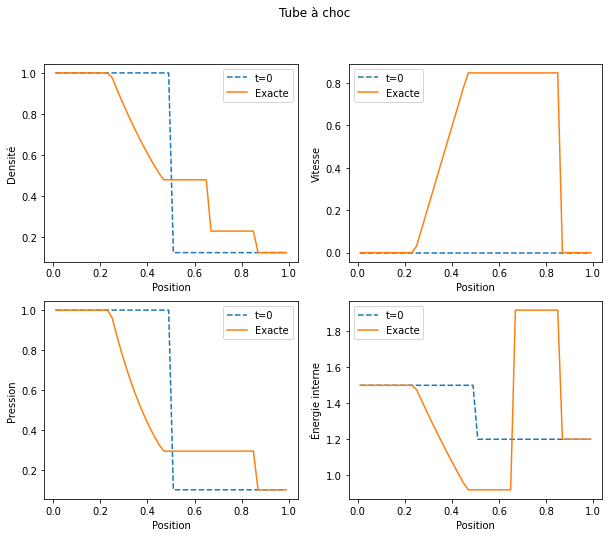

In [93]:
#                   TUBE À CHOC
#               Problème de Riemann
#
# Résolution des équations de l'hydrodynamique à 1d pour un tube à choc :
#           dt rho + dx (rho u) = 0
#           dt (rho u) + dx (rho u^{2} + P) = 0
#           dt E + dx (u(E + P)) = 0

# Solution exacte 1d extraite du Toro pout tube à choc

import numpy as np
import matplotlib.pyplot as plt

#from var_tac import * # Variables globales
#from exactTube import CI, SolveurExact # Solution exacte tube à choc

# Condition de positivité pour la pression
if (g4 * (c0l + c0r)) < (u0r - u0l) :
    print('Il faut inclure le vide')
else :
    print('ok')


## ----------------------------- Initialisation ----------------------------- ##
tab_rho0, tab_u0, tab_P0 = CI(x, inter, var_int0l, var_int0r)
tab_e0 = tab_P0 / tab_rho0 / g8

## ----------------------------- Solution exacte tube à choc ---------------- ##
print("-----------------------------")
print("Calcul solution exacte tube à choc")
tab_rhoExac, tab_uExac, tab_PExac, tab_eExac = SolveurExact(x, inter, var_int0l, var_int0r, timeout)
print('Temps final tube à choc = ', timeout)


## ----------------------------- Figures ------------------------------------ ##

plt.figure(figsize=(10,8))
plt.suptitle('Tube à choc')
plt.subplot(221)
plt.plot(x, tab_rho0, '--', label='t=0')
plt.plot(x, tab_rhoExac, label='Exacte')
plt.ylabel('Densité'); plt.xlabel('Position')
plt.legend()
plt.subplot(222)
plt.plot(x, tab_u0, '--', label='t=0')
plt.plot(x, tab_uExac, label='Exacte')
plt.ylabel('Vitesse'); plt.xlabel('Position')
plt.legend()
plt.subplot(223)
plt.plot(x, tab_P0,'--', label='t=0')
plt.plot(x, tab_PExac, label='Exacte')
plt.ylabel('Pression'); plt.xlabel('Position')
plt.legend()
plt.subplot(224)
plt.plot(x, tab_e0,'--', label='t=0')
plt.plot(x, tab_eExac, label='Exacte')
plt.ylabel('Énergie interne'); plt.xlabel('Position')
plt.legend()
plt.show()

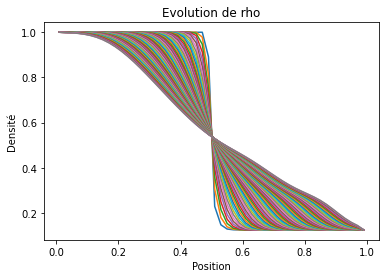

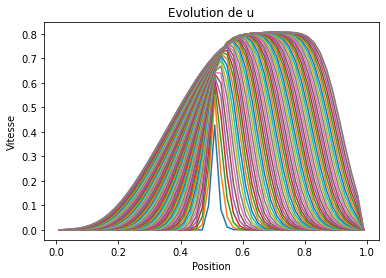

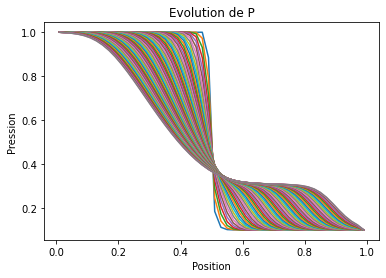

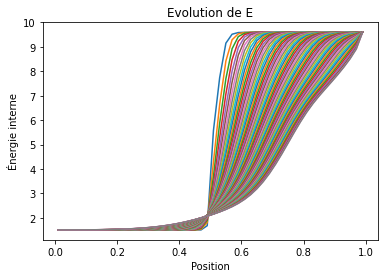

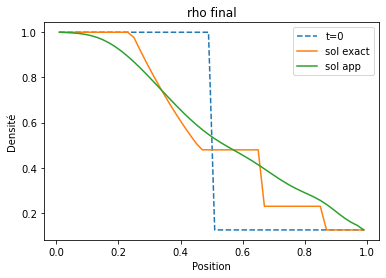

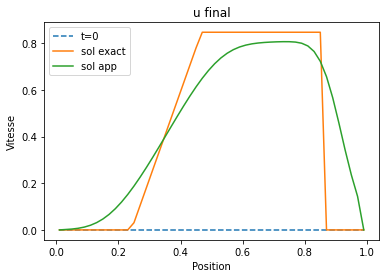

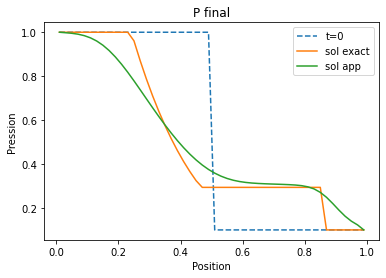

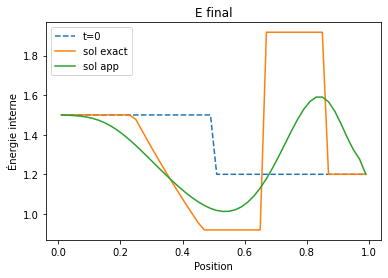

In [95]:
import numpy as np
import math
import matplotlib.pyplot as plt

#Conditions initiales Problème de Reimann :
def u0(Ncell,ul,ur):
    dx = 1/Ncell
    K = []
    x0 = 1/2*dx
    for i in range(Ncell):
        K.append(x0)
        x0 += dx
    x=np.array(K)
    ro = np.zeros(Ncell)
    u = np.zeros(Ncell)
    p = np.zeros(Ncell)
    for i in range(Ncell):
        if x[i]<inter:
            ro[i] = ul[0]
            u[i] = ul[1]
            p[i] = ul[2]
        if x[i]>inter:
            ro[i] = ur[0]
            u[i] = ur[1]
            p[i] = ur[2]
    return ro,u,p 

#la fonction flux :
def flux_f(u1,u2,u3,gamma):
    v1 = u2
    v2 = u2*u2/u1+(u3-u2*u2/u1/2)*(gamma-1)
    v3 = u3*u2/u1+(u3-u2*u2/u1/2)*(gamma-1)*u2/u1
    return v1,v2,v3

#Fonction valeur propre :
def vp(rho,u,p,gamma):
    c = np.sqrt(gamma*p/rho)
    return u-c,u,u+c

#Initialisation du temps final :
timeout=0.2      

#Initialisaton de ul :
ul = [1,0,1]

#Initialisation de ur :
ur = [0.125,0,0.1]

#Initialisation du temps courant :
t=0

#Initialisation de ro , u ,p ,ro_u, E :
ro,u,p = u0(Ncell,ul,ur)
ro_u=ro*u
E = p / g8 +0.5*ro_u**2/ro

#Boucle en Temps :
while t<timeout:
    
    vectp1,vectp2,vectp3 = vp(ro,u,gamma,p)
    a=max(vectp1)
    b=max(vectp2)
    c=max(vectp3)
    vmax = max(a,b,c)
    dt = dx/(4*vmax) #Condition CFL
    dt = min(dt,T-t)
    
    fro,fro_u,fE = flux_f(ro,ro_u,E,gamma)
    
    for i in range(1,Ncell-1):
        
        fGro = 1/2*(fro[i]+fro[i-1]) - vmax/2*(ro[i]-ro[i-1])
        fDro = 1/2*(fro[i+1]+fro[i]) - vmax/2*(ro[i+1]-ro[i])
        
        fGro_u = 1/2*(fro_u[i]+fro_u[i-1]) - vmax/2*(ro_u[i]-ro_u[i-1])
        fDro_u = 1/2*(fro_u[i+1]+fro_u[i]) - vmax/2*(ro_u[i+1]-ro_u[i])
        
        fGE = 1/2*(fE[i]+fE[i-1]) - vmax/2*(E[i]-E[i-1])
        fDE = 1/2*(fE[i+1]+fE[i]) - vmax/2*(E[i+1]-E[i])
        
        
        ro[i] = ro[i] - dt/dx*(fDro-fGro)
        ro_u[i] = ro_u[i] - dt/dx*(fDro_u-fGro_u)
        E[i] = E[i] - dt/dx*(fDE-fGE)

    plt.figure(1)
    plt.plot(x,ro)
    plt.ylabel('Densité'); plt.xlabel('Position')
    plt.title('Evolution de rho')
    
    plt.figure(2)
    plt.plot(x,ro_u/ro)
    plt.ylabel('Vitesse'); plt.xlabel('Position')
    plt.title('Evolution de u')
    
    plt.figure(3)
    plt.plot(x,g8*(E-0.5*ro_u**2/ro))
    plt.ylabel('Pression'); plt.xlabel('Position')
    plt.title('Evolution de P')
    
    
    plt.figure(4)
    plt.plot(x,(E-0.5*ro_u**2)/ro**2)
    plt.ylabel('Énergie interne'); plt.xlabel('Position')
    plt.title('Evolution de E')
    
    t = t + dt
    
#Visualisation de rho à l'instant initial/final et solution exacte :
plt.figure(5)
plt.plot(x, tab_rho0, '--', label='t=0')
plt.plot(x,tab_rhoExac,label = 'sol exact')
plt.plot(x,ro,label = 'sol app')
plt.ylabel('Densité'); plt.xlabel('Position')
plt.title("rho final")
plt.legend()

#Visualisation de u à l'instant initial/final et solution exacte :
plt.figure(6)
plt.plot(x, tab_u0, '--', label='t=0')
plt.plot(x,tab_uExac,label = 'sol exact')
plt.plot(x,ro_u/ro,label = 'sol app')
plt.ylabel('Vitesse'); plt.xlabel('Position')
plt.title("u final")
plt.legend()    

#Visualisation de P à l'instant initial/final et solution exacte :
plt.figure(7)
plt.plot(x, tab_P0,'--', label='t=0')
plt.title("P final")
plt.plot(x,tab_PExac,label = 'sol exact')
plt.plot(x,g8*(E-0.5*ro_u**2/ro),label = 'sol app')
plt.ylabel('Pression'); plt.xlabel('Position')
plt.legend()


#Visualisation de E à l'instant initial/final et solution exacte :
plt.figure(8)
plt.plot(x, tab_e0,'--', label='t=0')
plt.plot(x,tab_eExac,label = 'sol exact')
plt.plot(x,(E-0.5*ro_u**2/ro)/ro,label = 'sol app')
plt.ylabel('Énergie interne'); plt.xlabel('Position')
plt.title("E final")
plt.legend()
plt.show()